# Notebook to reproduce supplementary figure 3

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(sys.path[0], '../'))
from config import GEMINI_DIR
from plot import plot_utils, plot_settings

In [2]:
fig_dir = 'figure/supplementary_figure_3/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load the results

In [3]:
num_nets = [5, 10, 50, 100, 250, 505]
runtimes = {'gemini': [], 'mashup': [], 'bionic': []}  # method: list of runtimes
cpu_peak = {'gemini': [], 'mashup': [], 'bionic': []}  # method: list of peaks
gpu_peak = {'gemini': [], 'mashup': [], 'bionic': []}  # method: list of peaks

In [4]:
# first, do gemini.
for n in num_nets:
    with open(GEMINI_DIR + 'time_and_memory_study/monitoring_results/cluster:gemini_M={}_results.txt'.format(n), 'r') as f:
        res_cl = json.load(f)
    with open(GEMINI_DIR + 'time_and_memory_study/monitoring_results/gemini_M={}_results.txt'.format(n), 'r') as f:
        res_tr = json.load(f)
        
    runtimes['gemini'].append(float(res_cl['time (hrs)'] + res_tr['time (hrs)']) * 60)  # convert to seconds
    cpu_peak['gemini'].append(max(res_cl['peak CPU memory (MiB)'], res_tr['peak CPU memory (MiB)']))
    gpu_peak['gemini'].append(max(res_cl['peak GPU memory (MiB)'], res_tr['peak GPU memory (MiB)']))

In [5]:
# next, do mashup.
for n in num_nets:
    with open(GEMINI_DIR + 'time_and_memory_study/monitoring_results/gemini_M={}_results.txt'.format(n), 'r') as f:
        res = json.load(f)
        
    runtimes['mashup'].append(res['time (hrs)'] * 60)  # convert to seconds
    cpu_peak['mashup'].append(res['peak CPU memory (MiB)'])
    gpu_peak['mashup'].append(res['peak GPU memory (MiB)'])

In [6]:
# finally, do bionic.
for n in num_nets:
    with open(GEMINI_DIR + 'time_and_memory_study/monitoring_results/bionic_M={}_results.txt'.format(n), 'r') as f:
        res = json.load(f)
    num_ep = 10 if n <= 10 else 5 if n <= 100 else 2  # need to convert the training time to appropriate epoch num.
    total_ep = 1000
    
    tr_time = res['train time (hrs)'] * (total_ep / num_ep)
    runtimes['bionic'].append((tr_time + res['inference time (hrs)']) * 60)  # convert to seconds
    cpu_peak['bionic'].append(res['peak CPU memory (MiB)'])
    gpu_peak['bionic'].append(res['peak GPU memory (MiB)'])

# Now make the plot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


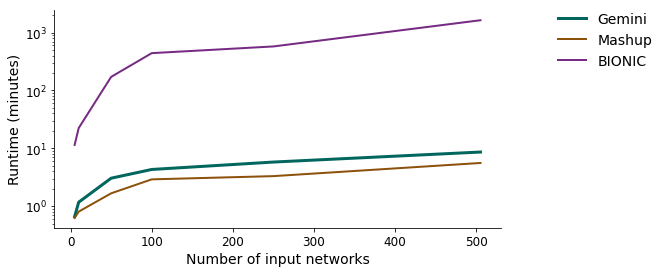

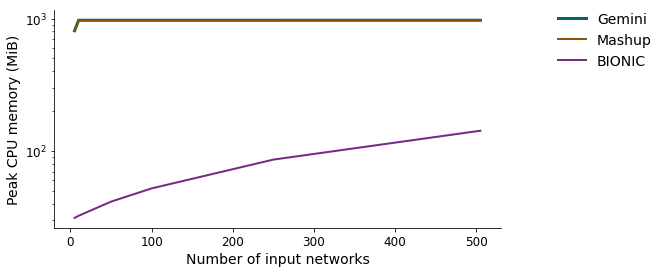

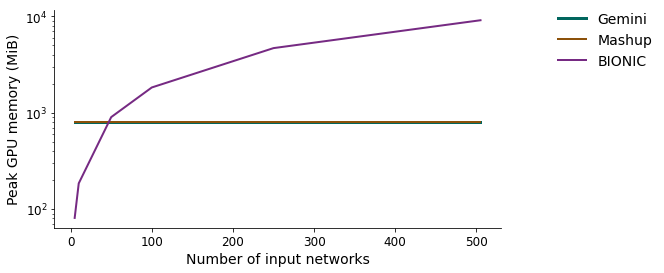

In [7]:
%matplotlib inline

for part, metric, results in zip(['a', 'b', 'c'], 
                                 ['Runtime (minutes)', 'Peak CPU memory (MiB)', 'Peak GPU memory (MiB)'],
                                 [runtimes, cpu_peak, gpu_peak]):
    ax = plot_settings.get_wider_axis(True)
    for method in results:
        plot_utils.line_plot(ax, results[method], xlabel='Number of input networks', ylabel=metric,
                             color=plot_settings.get_model_colors_by_network(method, 'Combo'), xdata=num_nets,
                             yscale='log', linewidth=2 if method != 'gemini' else 3,
                             label_marker=plot_settings.get_model_name_conventions(method))
    plot_utils.format_legend(ax, *ax.get_legend_handles_labels())
    plot_utils.put_legend_outside_plot(ax)
    plot_utils.format_ax(ax)
    plt.savefig(fig_dir + 'figure_S3_{}.pdf'.format(part), bbox_inches='tight')